In [5]:
import sys
sys.path.append('../..')

import numpy as np
from sklearn import datasets
import sklearn.ensemble
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import skimage
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images
from sklearn.datasets import fetch_mldata

In [6]:
mnist = fetch_mldata('MNIST original')
# make each image color so lime_image works correctly
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.reshape((-1, 28, 28))],0)
y_vec = mnist.target.astype(np.uint8)

/home/tiago/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/home/tiago/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


Text(0.5, 1.0, 'Digit: 0')

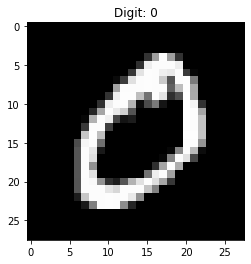

In [7]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])


In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.80)

In [52]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('Make Gray', <__main__.PipeStep object at 0x153e42605890>),
                ('Flatten Image', <__main__.PipeStep object at 0x153e426057d0>),
                ('RF',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [11]:
from density_lime import lime_image

In [17]:
from density_lime.kernel_density_exp import KernelDensityExp
from density_lime.kernel_density_exp_pca import KernelDensityExpPCA, KernelDensityExpKernelPCA
densit = KernelDensityExpPCA(n_components=100)

In [20]:
x_train_f = [rgb2gray(img) for img in X_train]
x_train_f = [img.ravel() for img in x_train_f]

In [24]:
densit.fit(x_train_f)

Text(0.5, 1.0, 'Digit: [4]')

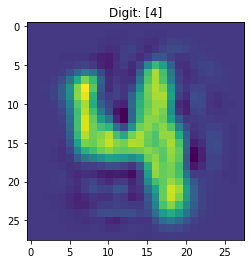

In [87]:
sample = densit.sample(n_samples=1).reshape((-1, 28, 28))
sample_f = [rgb2gray(img) for img in sample]
# sample_f = [img.ravel() for img in sample_f]

y = simple_rf_pipeline.predict(sample_f)
# sample_f.shape
fig, ax1 = plt.subplots(1,1)
ax1.imshow(sample_f[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y))


In [89]:
mean_explainer = lime_image.DensityImageExplainer(None)
density = densit
pcakde_explainer = lime_image.DensityImageExplainer(density)

In [90]:
pcakde_explainer.explain_instance(X_train[0], simple_rf_pipeline.predict_proba, top_labels=5, hide_color=None, num_samples=1000)

AttributeError: 'KernelDensityExpPCA' object has no attribute 'fill'